Copyright (C) 2025 Shaji R. Nathan/IP INFUSION INC.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

Description:
    A comprehensive machine learning framework for anomaly detection in network data.
    This module implements a complete ML pipeline including:
    - Data preprocessing and feature scaling
    - Handling imbalanced datasets using SMOTE and other techniques
    - Multiple classification algorithms (LogReg, SVM, Random Forest, Gradient Boosting)
    - Model evaluation with various metrics (ROC-AUC, Precision-Recall, F1)
    - Detailed visualization of results and model performance
    - Feature importance analysis and interpretation
    - Similar sample analysis for prediction explanation
    - Model persistence and result export capabilities

    The framework is designed to be easily extensible and configurable through
    a flexible configuration system that allows customization of preprocessing
    steps, model parameters, and evaluation metrics.

Author:
    Shaji R. Nathan
    CTO
    IP Infusion Inc.
    Email: snathanfax@gmail.com

Created:
    2025-02-17 - Initial implementation of anomaly detection framework

Modified:
    2025-02-17 - Added comprehensive visualization and analysis capabilities
                 Added model persistence and export functionality
                 Enhanced documentation and code organization

##### Version:
    1.0.0 - First stable release with complete functionality
    - Major (1): Initial release with complete feature set
    - Minor (0): No feature additions after initial release
    - Patch (0): No bug fixes yet

Dependencies:
    Core ML Libraries:
    - scikit-learn>=1.0.0 : Main ML functionality
    - imbalanced-learn>=0.8.0 : Handling imbalanced datasets
    
    Data Processing:
    - pandas>=1.3.0 : Data manipulation and analysis
    - numpy>=1.20.0 : Numerical computations
    
    Visualization:
    - matplotlib>=3.4.0 : Basic plotting capabilities
    - seaborn>=0.11.0 : Enhanced statistical visualizations
    
    Utilities:
    - joblib>=1.0.0 : Model persistence and parallel processing

Notes:
    - The framework currently assumes input data is in CSV format with the last column
      containing binary labels (0 for normal, 1 for anomaly)
    - All models are optimized for binary classification tasks
    - Feature scaling is automatically applied based on model requirements
    - Cross-validation is performed with stratified k-fold splitting
    - Model selection is based on ROC-AUC score by default
    
Example Usage:
    
    
    # Initialize detector
    detector = AnomalyDetector()
    
    # Load and prepare data
    detector.load_data('network_data.csv')
    detector.preprocess_data()
    
    # Train and evaluate models
    detector.train_models()
    detector.evaluate_models()
    
    # Select best model and make predictions
    best_model = detector.select_best_model()
    predictions = detector.predict(new_data)
    
    
    
  

For additional documentation and updates, please visit:
    https://github.com/snathanfax/anomaly-detection

Bug Reports and Feature Requests:
    Please submit issues and pull requests through the GitHub repository
    or contact the author directly at snathanfax@gmail.com

In [1]:
#Generic Class for anomaly detection classification 

# The code is organized as a class called `AnomalyDetector` that handles the entire machine learning pipeline.
#Here's a breakdown of the key components:

#1. Data Loading and Preprocessing:
#- Flexible CSV loading with automatic feature/target separation
#- StandardScaler for feature scaling
#- SMOTE implementation for handling imbalanced data
#- Train-test split functionality

#2. Visualization and Analysis:
#- Class distribution visualization
#- Feature correlation heatmap
#- Feature distribution box plots
#- ROC curves and AUC scores
#- Precision-Recall curves
#- Confusion matrices

#3. Multiple Classification Algorithms:
#- Logistic Regression
#- Support Vector Machine (SVM)
#- Decision Tree
#- Random Forest

#4. Model Evaluation:
#- ROC curves and AUC scores
#- Precision-Recall curves
#- Confusion matrices
#- Classification reports
#- Automatic best model selection based on AUC score

#To use this template in a Jupyter notebook, you would:

#1. Copy the code into a notebook cell
#2. Create an instance of the AnomalyDetector class
#3. Load your data using the load_data method
#4. Run through the pipeline methods in sequence
#5. Get predictions using the best model

#The code includes docstrings for all methods, so I hope it is easy to understand and modify as needed.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, 
    auc, precision_recall_curve, average_precision_score)
from imblearn.over_sampling import SMOTE
from collections import defaultdict
from datetime import datetime
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import numpy as np
import os
import pickle
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import set_config
from sklearn.utils import estimator_html_repr
from IPython.display import HTML, display
    
# Enable diagram display mode
set_config(display='diagram')

In [3]:
class AnomalyDetector:
    """
    A class for performing anomaly detection using various classification algorithms and pipelines.
    
    This class handles the entire ML pipeline including:
    - Data loading and preprocessing
    - Feature scaling 
    - Handling imbalanced data using SMOTE
    - Training multiple models using pipelines
    - Model evaluation and selection
    """
    
    def __init__(self):
        """Initialize the AnomalyDetector with empty attributes."""
        self.data = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None 
        self.y_train = None
        self.y_test = None
        self.models = {}
        self.pipelines = {}
        self.model_scores = defaultdict(dict)
        self.best_model = None

    def load_data(self, filepath):
        """
        Load data from CSV file and separate features and target.
        
        Parameters:
        -----------
        filepath : str
            Path to the CSV file containing the data
        """
        self.data = pd.read_csv(filepath)
        self.X = self.data.iloc[:, :-1]  # All columns except last
        self.y = self.data.iloc[:, -1]   # Last column only
        
    def visualize_data(self):
        """
        Perform basic statistical analysis and visualization of the raw data.
        """
        plt.figure(figsize=(15, 5))
        
        # Class distribution
        plt.subplot(131)
        sns.countplot(x=self.y)
        plt.title('Class Distribution')
        
        # Feature correlation heatmap
        plt.subplot(132)
        sns.heatmap(self.X.corr(), cmap='coolwarm')
        plt.title('Feature Correlation Matrix')
        
        # Box plot for feature distributions
        plt.subplot(133)
        self.X.boxplot()
        plt.title('Feature Distributions')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
    def create_pipeline(self):
        """
        Create scikit-learn pipeline that combines preprocessing and model steps.
        """
        # For numpy arrays, use indices instead of column names
        if isinstance(self.X_train, np.ndarray):
            numeric_features = list(range(self.X_train.shape[1]))
        else:
            numeric_features = self.X.columns.tolist()
            
        numeric_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())
            ]
        )

        # Combine preprocessing steps
        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, numeric_features),
            ]
        )

        # Create models if not already created
        if not self.models:
            self.models = {
                'Logistic Regression': LogisticRegression(max_iter=200, random_state=42),
                'SVM': SVC(probability=True, random_state=42),
                'Decision Tree': DecisionTreeClassifier(random_state=42),
                'Random Forest': RandomForestClassifier(random_state=42)
            }
            self.best_model = None
            self.best_score = None
            self.feature_columns = None

        # Create pipeline for each model 
        pipelines = {}
        for name, model in self.models.items():
            pipeline = Pipeline(
                steps=[
                    ("preprocessor", preprocessor),
                    ("classifier", model)
                ]
            )
            pipelines[name] = pipeline
            
        return pipelines
        
    def preprocess_data(self, test_size=0.2, random_state=42):
        """
        Preprocess the data including scaling and train-test split.
        """
        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state
        )
        
        # Convert to numpy arrays if not already
        self.X_train = np.asarray(self.X_train)
        self.X_test = np.asarray(self.X_test)
        self.y_train = np.asarray(self.y_train)
        self.y_test = np.asarray(self.y_test)
        
        # Apply SMOTE to handle imbalanced data
        smote = SMOTE(random_state=random_state)
        self.X_train, self.y_train = smote.fit_resample(self.X_train, self.y_train)
        
    def train_models(self):
        """
        Train multiple classification models using pipelines.
        """
        # Create and fit pipelines
        self.pipelines = self.create_pipeline()
        
        # Train each pipeline
        for name, pipeline in self.pipelines.items():
            pipeline.fit(self.X_train, self.y_train)
            
    def evaluate_models(self):
        """
        Evaluate all trained models using various metrics.
        """
        fig = plt.figure(figsize=(15, 10))
        
        # Plot ROC curves for all models
        ax1 = fig.add_subplot(221)
        for name, pipeline in self.pipelines.items():
            y_pred_proba = pipeline.predict_proba(self.X_test)[:, 1]
            fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            
            ax1.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
            self.model_scores[name]['AUC'] = roc_auc
            
        ax1.plot([0, 1], [0, 1], 'k--')
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title('ROC Curves')
        ax1.legend()
        
        # Plot Precision-Recall curves
        ax2 = fig.add_subplot(222)
        for name, pipeline in self.pipelines.items():
            y_pred_proba = pipeline.predict_proba(self.X_test)[:, 1]
            precision, recall, _ = precision_recall_curve(self.y_test, y_pred_proba)
            avg_precision = average_precision_score(self.y_test, y_pred_proba)
            
            ax2.plot(recall, precision, label=f'{name} (AP = {avg_precision:.2f})')
            self.model_scores[name]['AP'] = avg_precision
            
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_title('Precision-Recall Curves')
        ax2.legend()
        
        # Create confusion matrices
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
        
        for i, (name, pipeline) in enumerate(self.pipelines.items()):
            print(f"\nClassification Report for {name}:")
            y_pred = pipeline.predict(self.X_test)
            print(classification_report(self.y_test, y_pred))
            
            # Plot confusion matrix
            ax = ax3 if i < 2 else ax4
            cm = confusion_matrix(self.y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Confusion Matrix - {name}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            
        plt.tight_layout()
        plt.show()
        
    def select_best_model(self):
        """
        Select the best performing model based on AUC score.
        """
        best_auc = 0
        best_model_name = None
        
        for name, scores in self.model_scores.items():
            if scores['AUC'] > best_auc:
                best_auc = scores['AUC']
                best_model_name = name
                
        self.best_model = self.pipelines[best_model_name]
        print(f"\nBest performing model: {best_model_name} with AUC = {best_auc:.3f}")
        return best_model_name
    
    
    def visualize_pipeline(self, pipeline_name=None):
        """
        Visualize the ML pipeline using sklearn utilities.

        Parameters:
            pipeline_name (str, optional): Name of specific pipeline to visualize. 
                                         If None, visualizes all pipelines.
        """


        # Create pipelines if not already created
        if not hasattr(self, 'pipelines'):
            self.pipelines = self.create_pipeline()

        # Helper function to display pipeline with header
        def display_pipeline(name, pipeline):
            print(f"\n{'='*50}")
            print(f"Pipeline Block Diagram for: {name}")
            print(f"{'='*50}\n")
            display(HTML(estimator_html_repr(pipeline)))

        if pipeline_name:
            # Visualize specific pipeline
            if pipeline_name in self.pipelines:
                display_pipeline(pipeline_name, self.pipelines[pipeline_name])
            else:
                raise ValueError(f"Pipeline '{pipeline_name}' not found. Available pipelines: {list(self.pipelines.keys())}")
        else:
            # Visualize all pipelines
            for name, pipeline in self.pipelines.items():
                display_pipeline(name, pipeline)
                
                
    def save_best_model(self, filepath: str = None) -> str:
        """
        Save the best model to a pickle file.
        
        Args:
            filepath: Optional custom path for the pickle file.
                     If None, creates a timestamped file in the current directory.
        
        Returns:
            str: Path where the model was saved
        
        Raises:
            ValueError: If best model hasn't been determined yet
            IOError: If there's an error saving the file
        """
        if not hasattr(self, 'best_model') or self.best_model is None:
            raise ValueError("Best model hasn't been determined yet. Run model selection first.")
            
        # Create default filepath if none provided
        if filepath is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filepath = f"best_model_{timestamp}.pkl"
            
        try:
            # Create directory if it doesn't exist
            os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)
            
            # Save model information
            model_info = {
                'model_name': str(self.best_model),
                'model_object': self.best_model if not isinstance(self.best_model, str) else self.models[self.best_model],
                'model_score': self.best_score if hasattr(self, 'best_score') else None,
                'feature_columns': self.feature_columns if hasattr(self, 'feature_columns') else None,
                'timestamp': datetime.now().isoformat()
            }
            
            with open(filepath, 'wb') as f:
                pickle.dump(model_info, f)
                
            print(f"Model saved successfully to: {filepath}")
            return filepath
            
        except Exception as e:
            raise IOError(f"Error saving model: {str(e)}")
    
    def retrieve_best_model(self, filepath: str) -> dict:
        """
        Load the best model from a pickle file.
        
        Args:
            filepath: Path to the pickle file containing the saved model
            
        Returns:
            dict: Dictionary containing model information including:
                - model_name: Name of the best model
                - model_object: The actual model object
                - model_score: Score of the model (if available)
                - feature_columns: Feature columns used (if available)
                - timestamp: When the model was saved
                
        Raises:
            FileNotFoundError: If the model file doesn't exist
            IOError: If there's an error loading the file
        """
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Model file not found: {filepath}")
            
        try:
            with open(filepath, 'rb') as f:
                model_info = pickle.load(f)
                
            # Update class attributes with loaded model
            self.best_model = model_info['model_object']  # Store the actual model object
            if isinstance(model_info['model_name'], str) and model_info['model_name'] in self.models:
                self.models[model_info['model_name']] = model_info['model_object']
            if model_info.get('model_score') is not None:
                self.best_score = model_info['model_score']
            if model_info.get('feature_columns') is not None:
                self.feature_columns = model_info['feature_columns']
                
            print(f"Model loaded successfully from: {filepath}")
            return model_info
            
        except Exception as e:
            raise IOError(f"Error loading model: {str(e)}")

In [4]:
# Initialize detector
detector = AnomalyDetector()


In [5]:
# Load and visualize data
detector.load_data('./BgpData/Nimda.csv')


####  BGP datasets

##### The data for the known anomalies was obtained from the IEEE dataport. 

https://ieee-dataport.org/open-access/border-gateway-protocol-bgp-routing-records-reseaux-ip-europeens-ripe-and-bcnet  

The Description of the dataset containing well known attacks was in the readme file, which I am copying and pasting verbatim:

### Background info for the BGP DDOS attacks: 

Five well-known Border Gateway Anomalies (BGP) anomalies WannaCrypt, Moscow blackout, Slammer, Nimda, Code Red I, occurred in May 2017, May 2005, January 2003, September 2001, and July 2001, respectively. The Reseaux IP Europeens (RIPE) BGP update messages are publicly available from the Network Coordination Centre (NCC) and contain: WannaCrypt, Moscow blackout, Slammer, Nimda, Code Red I, and regular data: https://www.ripe.net/analyse/. Regular data are also collected from BCNET: http://www.bc.net/.
- WannaCrypt (WannaCry) is a cryptoworm ransomware that works by gaining administrative privileges and employs the EternalBlue exploit and DoublePulsar backdoor in systems running Microsoft Windows 7.
- The Chagino substation of the Moscow energy ring experienced a transformer failure on May 24, 2005 at 20:57 (MSK). The event caused a complete shutdown of the substation and a blackout that affected all customer until 16:00 (MSK) of May 26, 2005. During the blackout, the Internet traffic exchange point MSK-IX was disconnected from 11:00 to 17:00 (MSK).
- Slammer infected Microsoft SQL servers through a small piece of code that generated IP addresses at random. The number of infected machines doubled approximately every 9 seconds.
- Nimda exploited vulnerabilities in the Microsoft Internet Information Services (IIS) web servers for Internet Explorer 5. The worm propagated by sending an infected attachment that was automatically downloaded once the email was viewed.
- The Code Red I worm attacked Microsoft IIS web servers by replicating itself through IIS server weaknesses Unlike the Slammer worm, Code Red I searched for vulnerable servers to infect. The rate of infection was doubling every 37 minutes.

37 features are extracted from BGP update messages that originated from AS 513 (route collector rrc 04). The data collected during periods of Internet anomalies include:
- eight-day period for WannaCrypt (four days of the attack as well as two days prior and two days after the attack);
- five-day period for Moscow blackout, Slammer, and Code Red I (the day of the attack as well as two days prior and two days after the attack);
- six-day period for Nimda (two days of the attack as well as two days prior and two days after the attack). Note that there are 31 missing data points in the Nimda dataset. 



For this analysis I am just going to use one type of DDOS attack file to test the code. Feel free to create a bigger data set to experiment. Let me know what you found out when used against new data from your BGP network. Did the model work or was it way off. 

In [6]:
#Display the dataframe to get a general idea

detector.data.head()

,0,0.1,0.2,8,64,1,123,4,6,11,...,0.17,0.18,0.19,0.20,0.21,57,0.22,7,242,-1
0,1,0,1,7,47,5,160,29,6,11,...,0,0,0,0,0,24,0,23,273,-1
1,2,0,2,6,37,5,77,18,5,9,...,0,0,0,0,0,29,0,8,233,-1
2,3,0,3,2,34,5,76,21,6,11,...,0,0,0,0,0,26,0,8,252,-1
3,4,0,4,4,29,4,92,13,6,9,...,0,0,0,0,0,24,0,5,261,-1
4,5,0,5,0,37,3,138,5,5,8,...,0,0,0,0,0,26,0,11,273,-1


### Here's how to read the dataframe displayed above

### Description of the fields in the csv files:

Columns 1-4: time (column 1: hour+minute; column 2: hour; column 3: minute; column 4: second)
Columns 5-41: features
Column 42: labels for the regular (-1) and anomalous (1) data.

#### n.b: If you use neural networks (for example RNN ) , the PyTorch library requires that label (-1) be changed to (0). So be aware of that 

List of features extracted from BGP update messages:
1 Number of announcements
2 Number of withdrawals
3 Number of announced NLRI prefixes
4 Number of withdrawn NLRI prefixes
5 Average AS-path length
6 Maximum AS-path length
7 Average unique AS-path length
8 Number of duplicate announcements
9 Number of duplicate withdrawals
10 Number of implicit withdrawals
11 Average edit distance
12 Maximum edit distance
13 Inter-arrival time
14–24 Maximum edit distance = n, n = 7, . . . , 17
25–33 Maximum AS-path length = n, n = 7, . . . , 15
34 Number of Interior Gateway Protocol (IGP) packets
35 Number of Exterior Gateway Protocol (EGP) packets
36 Number of incomplete packets
37 Packet size (B)

In [7]:
detector.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8608 entries, 0 to 8607
Data columns (total 42 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       8608 non-null   int64  
 1   0.1     8608 non-null   int64  
 2   0.2     8608 non-null   int64  
 3   8       8608 non-null   int64  
 4   64      8608 non-null   int64  
 5   1       8608 non-null   int64  
 6   123     8608 non-null   int64  
 7   4       8608 non-null   int64  
 8   6       8608 non-null   int64  
 9   11      8608 non-null   int64  
 10  6.1     8608 non-null   int64  
 11  1.1     8608 non-null   int64  
 12  49      8608 non-null   int64  
 13  0.3     8608 non-null   int64  
 14  11.1    8608 non-null   int64  
 15  1.2     8608 non-null   float64
 16  6.2     8608 non-null   int64  
 17  1.3     8608 non-null   int64  
 18  0.4     8608 non-null   int64  
 19  0.5     8608 non-null   int64  
 20  0.6     8608 non-null   int64  
 21  0.7     8608 non-null   int64  
 22  

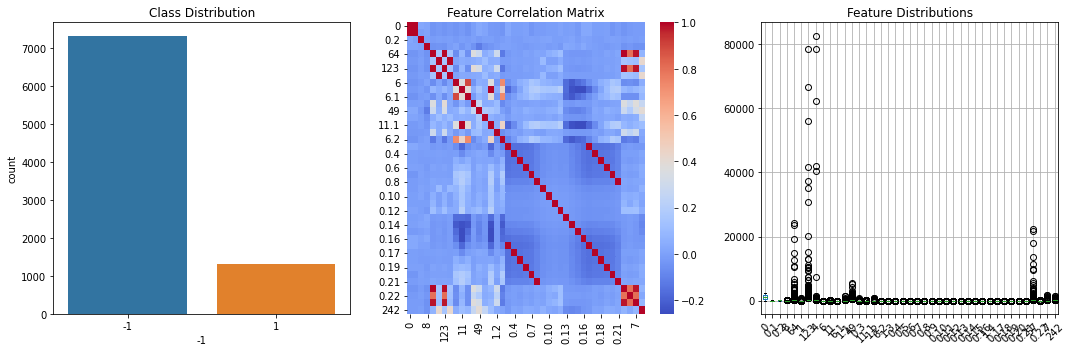

In [8]:
# Visualize the data to get a general sense
#  Busy visualization, will clean up later. This will do for now

detector.visualize_data()

In [9]:
# Preprocess data
detector.preprocess_data()

In [10]:
# Train models
detector.train_models()

In [11]:
# Visualize single pipeline
#detector.visualize_pipeline('Random Forest')

# visualize all pipelines
detector.visualize_pipeline()


Pipeline Block Diagram for: Logistic Regression




Pipeline Block Diagram for: SVM




Pipeline Block Diagram for: Decision Tree




Pipeline Block Diagram for: Random Forest




Classification Report for Logistic Regression:
              precision    recall  f1-score   support

          -1       0.97      0.84      0.90      1452
           1       0.49      0.84      0.62       270

    accuracy                           0.84      1722
   macro avg       0.73      0.84      0.76      1722
weighted avg       0.89      0.84      0.85      1722


Classification Report for SVM:
              precision    recall  f1-score   support

          -1       0.94      0.96      0.95      1452
           1       0.74      0.67      0.71       270

    accuracy                           0.91      1722
   macro avg       0.84      0.81      0.83      1722
weighted avg       0.91      0.91      0.91      1722


Classification Report for Decision Tree:
              precision    recall  f1-score   support

          -1       0.93      0.92      0.93      1452
           1       0.61      0.63      0.62       270

    accuracy                           0.88      1722
   mac

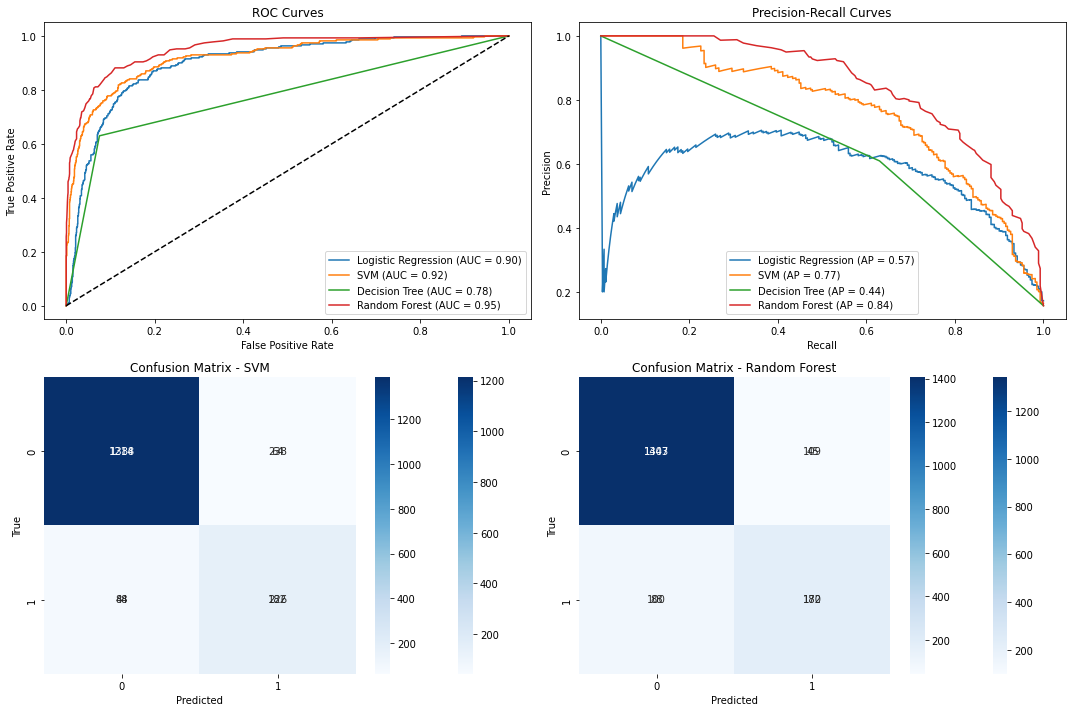


Best performing model: Random Forest with AUC = 0.951


In [12]:
# Evaluate and select best model
detector.evaluate_models()
best_model = detector.select_best_model()

In [13]:
 # Visualize pipeline for best model
detector.visualize_pipeline(best_model)


Pipeline Block Diagram for: Random Forest



In [14]:
# Specify custom path to save the best model with timestamps
# I have a models directory within the local directory to save the best model

model_path = detector.save_best_model("./models/current_best_model.pkl")

Model saved successfully to: ./models/current_best_model.pkl


###  A flexible Test method to do predictions using the best model and random rows from the BGP dataset

In [15]:
import numpy as np
import pandas as pd
from typing import Tuple, List, Union
from sklearn.base import BaseEstimator

In [16]:
def predict_sample_anomalies(
    model: Union[BaseEstimator, str],
    dataframe: pd.DataFrame,
    feature_columns: List[str],
    model_dict: dict,
    n_samples: int,
    random_state: int = None
) -> Tuple[pd.DataFrame, np.ndarray]:
    """
    Randomly selects rows from the dataframe and predicts anomalies using the provided model.
    
    Args:
        model: Either a trained sklearn model or a string key from model_dict
        dataframe: Input DataFrame containing the features
        feature_columns: List of column names to use as features
        model_dict: Dictionary of models if model parameter is a string key
        n_samples: Number of random samples to select
        random_state: Random seed for reproducibility (default: None)
    
    Returns:
        Tuple containing:
        - DataFrame with the selected samples
        - numpy array with prediction results
    
    Example:
        >>> detector = AnomalyDetector()
        >>> n_samples = int(input("Enter number of samples: "))
        >>> features = detector.data.columns[:-1].tolist()
        >>> samples, predictions = predict_sample_anomalies(
        ...     'Random Forest',
        ...     detector.data,
        ...     features,
        ...     detector.models,
        ...     n_samples
        ... )
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Handle model selection
    if isinstance(model, str):
        if model not in model_dict:
            raise ValueError(f"Model key '{model}' not found in model_dict. Available models: {list(model_dict.keys())}")
        model = model_dict[model]
    
    # Validate that model has predict method
    if not hasattr(model, 'predict'):
        raise ValueError("Model must have a predict method")
    
    # Validate input
    if n_samples > len(dataframe):
        raise ValueError(f"n_samples ({n_samples}) cannot be larger than the dataset size ({len(dataframe)})")
    
    if not all(col in dataframe.columns for col in feature_columns):
        missing_cols = [col for col in feature_columns if col not in dataframe.columns]
        raise ValueError(f"Features {missing_cols} not found in dataframe")
    
    # Randomly select n_samples rows
    random_indices = np.random.choice(
        len(dataframe), 
        size=n_samples, 
        replace=False
    )
    sample_df = dataframe.iloc[random_indices].copy()
    
    # Extract features for prediction
    X_sample = sample_df[feature_columns].values
    
    try:
        # Make predictions
        predictions = model.predict(X_sample)
        
        # Add prediction results to the sample dataframe
        sample_df['prediction'] = predictions
        
        return sample_df, predictions
        
    except Exception as e:
        raise RuntimeError(f"Error making predictions: {str(e)}")

In [17]:
#  'models' folder in current directory where we saved the best_model

model_path = "./models/current_best_model.pkl"  


# Load the saved version of the best model
new_detector = AnomalyDetector()

model_info = new_detector.retrieve_best_model(model_path)



Model loaded successfully from: ./models/current_best_model.pkl


In [18]:
# Load the incoming bgp data into the new detector
# I am going to use some newly captured data for now 

new_detector.load_data('./BgpData/BCNET_regular.csv')  

In [19]:
# Use the loaded model for predictions and get number of samples to predict from end user

n_samples = int(input("Please enter the number of new bgp data samples to predict (example 4 as in 4 rows of new data): "))

feature_columns = new_detector.data.columns[:-1].tolist()
samples, predictions = predict_sample_anomalies(
    new_detector.best_model,
    new_detector.data,
    feature_columns,
    new_detector.models,
    n_samples
)

# Print results
print("\n\nSelected Samples:")
print(samples)
print("\nPredictions:", predictions)

Please enter the number of new bgp data samples to predict (example 4 as in 4 rows of new data): 6


Selected Samples:
         0  0.1  0.2  0.3  57   8  203   16  6  15  ...  0.19  0.20  0.21  \
336    537    5   37    0  63   9  215   26  5   9  ...     0     0     0   
293    454    4   54    0  80  11  434   26  6  14  ...     0     0     0   
1222  2023   20   23    0  41   6  227   55  5  11  ...     0     0     0   
843   1404   14    4    0  44   8  295   24  6  11  ...     0     0     0   
116    157    1   57    0  82  13  420   23  5  10  ...     0     0     0   
378    619    6   19    0  50  13  243  131  6  10  ...     0     0     0   

      0.22  60  0.23  0.24  8079  -1  prediction  
336      0  65     0     0  7583  -1          -1  
293      0  81     0     0  9225  -1          -1  
1222     0  43     0     0  9051  -1          -1  
843      0  48     0     0  8440  -1          -1  
116      0  85     0     0  8868  -1          -1  
378      0  53     0     0  8972  -

### Here is how to read the inference output 

If the prediction is -1 the traffic is normal, a 1 indicates an anomaly in the bgp traffic